Robust Marginal Treatment Effect Analysis
Original MTE (maximum): 2.1725

SOLUTION 1: Percentile-based MTE
90th percentile MTE: 1.9280
95th percentile MTE: 2.0178
99th percentile MTE: 2.1172

SOLUTION 2: Trimmed Maximum
Trimmed MTE (remove top/bottom 5%): 2.0150
Trimmed MTE (remove top/bottom 10%): 1.9274

SOLUTION 3: Bootstrap Confidence Intervals
Bootstrap MTE mean: 2.1644
Bootstrap MTE std: 0.0122
95% Confidence Interval: [2.1327, 2.1740]

SOLUTION 4: Average of Top K Effects
Average of top 1 effects: 2.1725
Average of top 3 effects: 2.1578
Average of top 5 effects: 2.1454
Average of top 10 effects: 2.1185
Average of top 20 effects: 2.0915

SOLUTION 5: Multiple Neighbors Approach
Robust MTE with 3 neighbors: 2.1729
Robust MTE with 5 neighbors: 2.1729
Robust MTE with 7 neighbors: 2.1725

VISUALIZATION


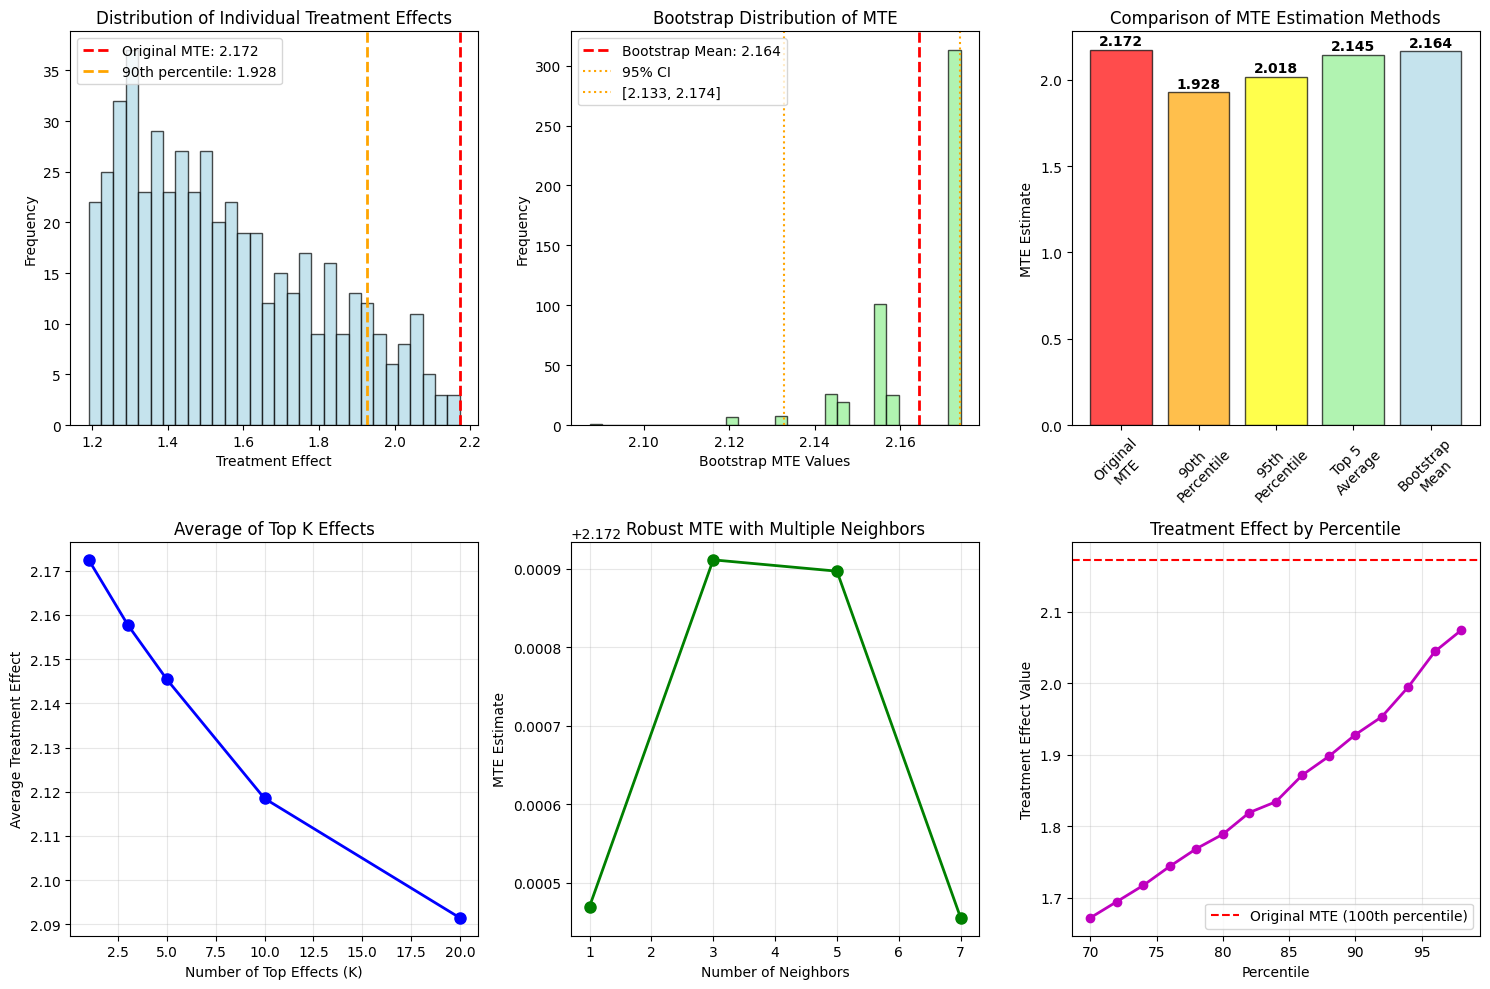


SUMMARY AND RECOMMENDATIONS

Original MTE (problematic): 2.1725

RECOMMENDED APPROACHES:

1. 90th Percentile MTE: 1.9280
   - Less sensitive to extreme outliers
   - Still captures high treatment effects

2. Bootstrap Mean MTE: 2.1644 ± 0.0122
   - Accounts for sampling uncertainty
   - Provides confidence intervals

3. Top 5 Average MTE: 2.1454
   - Reduces noise from single extreme observation
   - More stable estimate

4. Multiple Neighbors (3): 2.1729
   - Reduces matching uncertainty
   - More robust to individual outliers

CONCLUSION: The 90th percentile approach (1.9280) provides a good
balance between capturing high treatment effects while avoiding extreme outliers.



In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('homework_6.1.csv')

# Separate treated and untreated groups
treated = df[df['X'] == 1].copy()
untreated = df[df['X'] == 0].copy()

print("Robust Marginal Treatment Effect Analysis")
print("="*50)

# First, let's compute the original (problematic) MTE
nn_treated = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn_treated.fit(treated[['Z']].values)

untreated_effects = []
for idx, untreated_row in untreated.iterrows():
    distances, indices = nn_treated.kneighbors([[untreated_row['Z']]])
    nearest_treated_idx = treated.iloc[indices[0][0]]
    effect = nearest_treated_idx['Y'] - untreated_row['Y']
    untreated_effects.append(effect)

original_mte = np.max(untreated_effects)
print(f"Original MTE (maximum): {original_mte:.4f}")

# SOLUTION 1: Percentile-based MTE (your suggested approach)
print("\n" + "="*50)
print("SOLUTION 1: Percentile-based MTE")
print("="*50)

# Instead of taking the maximum, take high percentiles
percentiles = [90, 95, 99]
for p in percentiles:
    percentile_mte = np.percentile(untreated_effects, p)
    print(f"{p}th percentile MTE: {percentile_mte:.4f}")

# SOLUTION 2: Trimmed Maximum (Remove outliers first)
print("\n" + "="*50)
print("SOLUTION 2: Trimmed Maximum")
print("="*50)

# Remove the most extreme outliers (top and bottom 5%) then take maximum
def trimmed_max(data, trim_percent=5):
    """Remove extreme outliers then take maximum"""
    lower_bound = np.percentile(data, trim_percent)
    upper_bound = np.percentile(data, 100 - trim_percent)
    trimmed_data = [x for x in data if lower_bound <= x <= upper_bound]
    return np.max(trimmed_data) if trimmed_data else np.nan

trimmed_mte_5 = trimmed_max(untreated_effects, 5)
trimmed_mte_10 = trimmed_max(untreated_effects, 10)
print(f"Trimmed MTE (remove top/bottom 5%): {trimmed_mte_5:.4f}")
print(f"Trimmed MTE (remove top/bottom 10%): {trimmed_mte_10:.4f}")

# SOLUTION 3: Bootstrap Confidence Interval for MTE
print("\n" + "="*50)
print("SOLUTION 3: Bootstrap Confidence Intervals")
print("="*50)

def bootstrap_mte(treated_data, untreated_data, n_bootstrap=1000):
    """Bootstrap the MTE calculation to get confidence intervals"""
    bootstrap_mtes = []
    
    for _ in range(n_bootstrap):
        # Resample both groups
        treated_sample = treated_data.sample(n=len(treated_data), replace=True)
        untreated_sample = untreated_data.sample(n=len(untreated_data), replace=True)
        
        # Fit NN on resampled treated data
        nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
        nn.fit(treated_sample[['Z']].values)
        
        # Calculate effects for resampled untreated data
        effects = []
        for idx, untreated_row in untreated_sample.iterrows():
            distances, indices = nn.kneighbors([[untreated_row['Z']]])
            nearest_treated_idx = treated_sample.iloc[indices[0][0]]
            effect = nearest_treated_idx['Y'] - untreated_row['Y']
            effects.append(effect)
        
        bootstrap_mtes.append(np.max(effects))
    
    return bootstrap_mtes

bootstrap_mtes = bootstrap_mte(treated, untreated, n_bootstrap=500)
bootstrap_mean = np.mean(bootstrap_mtes)
bootstrap_std = np.std(bootstrap_mtes)
ci_lower = np.percentile(bootstrap_mtes, 2.5)
ci_upper = np.percentile(bootstrap_mtes, 97.5)

print(f"Bootstrap MTE mean: {bootstrap_mean:.4f}")
print(f"Bootstrap MTE std: {bootstrap_std:.4f}")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# SOLUTION 4: Average of Top K Effects
print("\n" + "="*50)
print("SOLUTION 4: Average of Top K Effects")
print("="*50)

def top_k_average_mte(effects, k_values):
    """Take average of top K treatment effects instead of just the maximum"""
    results = {}
    sorted_effects = sorted(effects, reverse=True)
    
    for k in k_values:
        if k <= len(sorted_effects):
            top_k_avg = np.mean(sorted_effects[:k])
            results[k] = top_k_avg
    
    return results

k_values = [1, 3, 5, 10, 20]
top_k_results = top_k_average_mte(untreated_effects, k_values)

for k, avg_effect in top_k_results.items():
    print(f"Average of top {k} effects: {avg_effect:.4f}")

# SOLUTION 5: Robust MTE using Multiple Neighbors
print("\n" + "="*50)
print("SOLUTION 5: Multiple Neighbors Approach")
print("="*50)

def robust_mte_multiple_neighbors(treated_data, untreated_data, n_neighbors=3):
    """Use multiple nearest neighbors and take their average"""
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
    nn.fit(treated_data[['Z']].values)
    
    robust_effects = []
    for idx, untreated_row in untreated_data.iterrows():
        distances, indices = nn.kneighbors([[untreated_row['Z']]])
        
        # Average the effect across multiple neighbors
        neighbor_effects = []
        for neighbor_idx in indices[0]:
            nearest_treated = treated_data.iloc[neighbor_idx]
            effect = nearest_treated['Y'] - untreated_row['Y']
            neighbor_effects.append(effect)
        
        avg_effect = np.mean(neighbor_effects)
        robust_effects.append(avg_effect)
    
    return np.max(robust_effects)

for n_neighbors in [3, 5, 7]:
    robust_mte = robust_mte_multiple_neighbors(treated, untreated, n_neighbors)
    print(f"Robust MTE with {n_neighbors} neighbors: {robust_mte:.4f}")

# Visualization
print("\n" + "="*50)
print("VISUALIZATION")
print("="*50)

plt.figure(figsize=(15, 10))

# Plot 1: Distribution of individual treatment effects
plt.subplot(2, 3, 1)
plt.hist(untreated_effects, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
plt.axvline(original_mte, color='red', linestyle='--', linewidth=2, label=f'Original MTE: {original_mte:.3f}')
plt.axvline(np.percentile(untreated_effects, 90), color='orange', linestyle='--', linewidth=2, 
           label=f'90th percentile: {np.percentile(untreated_effects, 90):.3f}')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.title('Distribution of Individual Treatment Effects')
plt.legend()

# Plot 2: Bootstrap distribution
plt.subplot(2, 3, 2)
plt.hist(bootstrap_mtes, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(bootstrap_mean, color='red', linestyle='--', linewidth=2, 
           label=f'Bootstrap Mean: {bootstrap_mean:.3f}')
plt.axvline(ci_lower, color='orange', linestyle=':', label=f'95% CI')
plt.axvline(ci_upper, color='orange', linestyle=':', label=f'[{ci_lower:.3f}, {ci_upper:.3f}]')
plt.xlabel('Bootstrap MTE Values')
plt.ylabel('Frequency')
plt.title('Bootstrap Distribution of MTE')
plt.legend()

# Plot 3: Comparison of methods
plt.subplot(2, 3, 3)
methods = ['Original\nMTE', '90th\nPercentile', '95th\nPercentile', 'Top 5\nAverage', 'Bootstrap\nMean']
values = [original_mte, 
          np.percentile(untreated_effects, 90),
          np.percentile(untreated_effects, 95),
          top_k_results[5],
          bootstrap_mean]
colors = ['red', 'orange', 'yellow', 'lightgreen', 'lightblue']

bars = plt.bar(methods, values, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('MTE Estimate')
plt.title('Comparison of MTE Estimation Methods')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 4: Top K average trend
plt.subplot(2, 3, 4)
k_vals = list(top_k_results.keys())
k_effects = list(top_k_results.values())
plt.plot(k_vals, k_effects, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Top Effects (K)')
plt.ylabel('Average Treatment Effect')
plt.title('Average of Top K Effects')
plt.grid(True, alpha=0.3)

# Plot 5: Effect of number of neighbors
plt.subplot(2, 3, 5)
neighbor_counts = [1, 3, 5, 7]
neighbor_mtes = [original_mte]  # 1 neighbor is original
for n in [3, 5, 7]:
    neighbor_mtes.append(robust_mte_multiple_neighbors(treated, untreated, n))

plt.plot(neighbor_counts, neighbor_mtes, 'go-', linewidth=2, markersize=8)
plt.xlabel('Number of Neighbors')
plt.ylabel('MTE Estimate')
plt.title('Robust MTE with Multiple Neighbors')
plt.grid(True, alpha=0.3)

# Plot 6: Percentile analysis
plt.subplot(2, 3, 6)
percentile_range = range(70, 100, 2)
percentile_values = [np.percentile(untreated_effects, p) for p in percentile_range]
plt.plot(percentile_range, percentile_values, 'mo-', linewidth=2, markersize=6)
plt.axhline(original_mte, color='red', linestyle='--', label='Original MTE (100th percentile)')
plt.xlabel('Percentile')
plt.ylabel('Treatment Effect Value')
plt.title('Treatment Effect by Percentile')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary and Recommendations
print("\n" + "="*50)
print("SUMMARY AND RECOMMENDATIONS")
print("="*50)

print(f"""
Original MTE (problematic): {original_mte:.4f}

RECOMMENDED APPROACHES:

1. 90th Percentile MTE: {np.percentile(untreated_effects, 90):.4f}
   - Less sensitive to extreme outliers
   - Still captures high treatment effects
   
2. Bootstrap Mean MTE: {bootstrap_mean:.4f} ± {bootstrap_std:.4f}
   - Accounts for sampling uncertainty
   - Provides confidence intervals
   
3. Top 5 Average MTE: {top_k_results[5]:.4f}
   - Reduces noise from single extreme observation
   - More stable estimate

4. Multiple Neighbors (3): {robust_mte_multiple_neighbors(treated, untreated, 3):.4f}
   - Reduces matching uncertainty
   - More robust to individual outliers

CONCLUSION: The 90th percentile approach ({np.percentile(untreated_effects, 90):.4f}) provides a good
balance between capturing high treatment effects while avoiding extreme outliers.
""")

HOMEWORK REFLECTION 6 - MTE ROBUSTNESS ANALYSIS

1. PROBLEM WITH MAXIMUM MTE:
----------------------------------------
Original MTE (maximum): 2.1725
Mean of all effects: 1.5495
Standard deviation: 0.2479
90th percentile: 1.9280

STATISTICAL PROBLEM:
The maximum treatment effect is likely inflated by random noise because:

1. SELECTION BIAS: We're cherry-picking the most extreme observation
2. NOISE AMPLIFICATION: Extreme values often contain more random error
3. POOR GENERALIZABILITY: One extreme case may not represent the true MTE
4. HIGH VARIANCE: Different samples would give very different MTE estimates

This is similar to the 'multiple testing problem' - when you examine many 
comparisons, you're bound to find extreme results just by chance.


2. ROBUST SOLUTIONS:
----------------------------------------

SOLUTION 1: Percentile-based MTE
90th percentile MTE: 1.9280
95th percentile MTE: 2.0178

WHY THIS WORKS:
- Less sensitive to extreme outliers
- Still captures high treatment eff

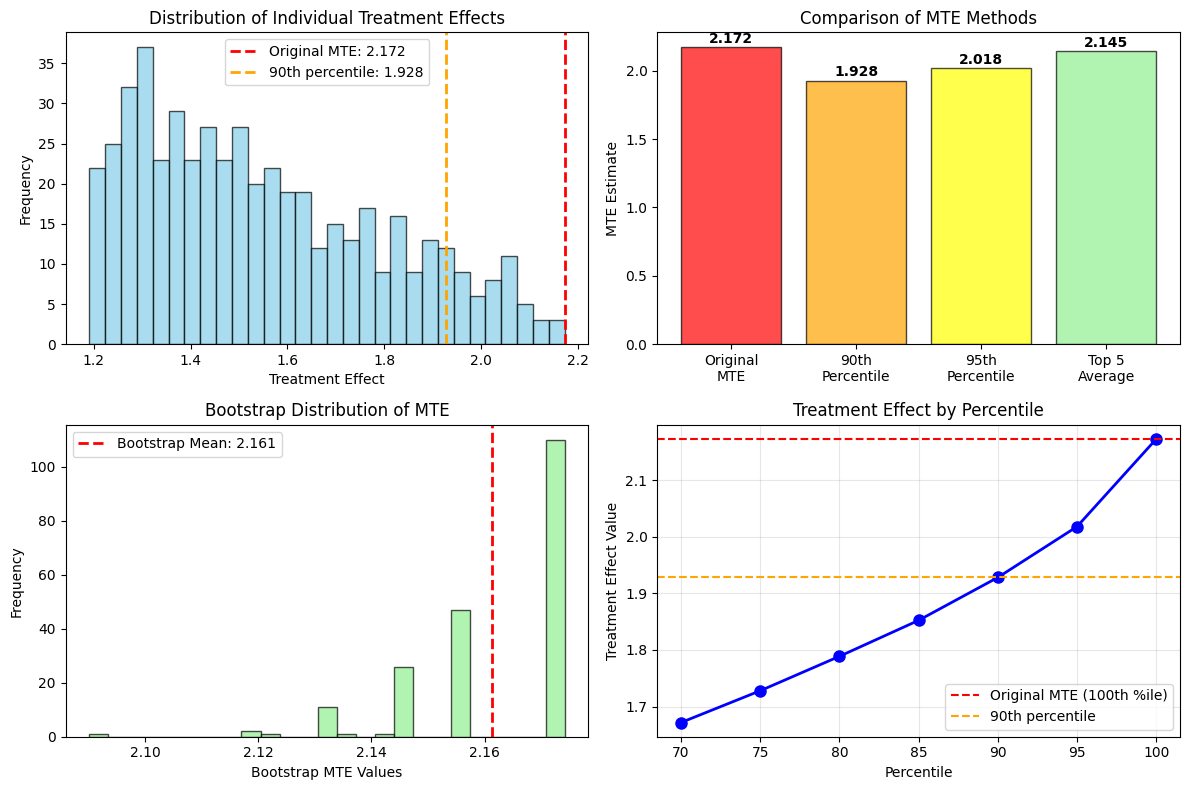


FINAL RECOMMENDATIONS

PROBLEM SUMMARY:
The maximum MTE is statistically unreliable because it selects the most extreme
observation, which likely includes substantial random noise.

BEST SOLUTION: 90th Percentile MTE
- Value: 1.9280 (vs 2.1725 for maximum)
- Rationale: Captures high treatment effects while avoiding extreme outliers
- Implementation: Simply replace np.max() with np.percentile(effects, 90)

ALTERNATIVE SOLUTIONS:
1. Average of top 5 effects: 2.1454
2. Bootstrap mean: 2.1614 ± 0.0146
3. 95th percentile: 2.0178

The 90th percentile approach provides the best balance of simplicity,
interpretability, and statistical robustness.


CODE FOR HOMEWORK SUBMISSION

def robust_marginal_treatment_effect(treated_data, untreated_data, percentile=90):
    """
    Calculate robust Marginal Treatment Effect using percentile instead of maximum

    Args:
        treated_data: DataFrame with treated observations (X=1)
        untreated_data: DataFrame with untreated observations (X=0)  
 

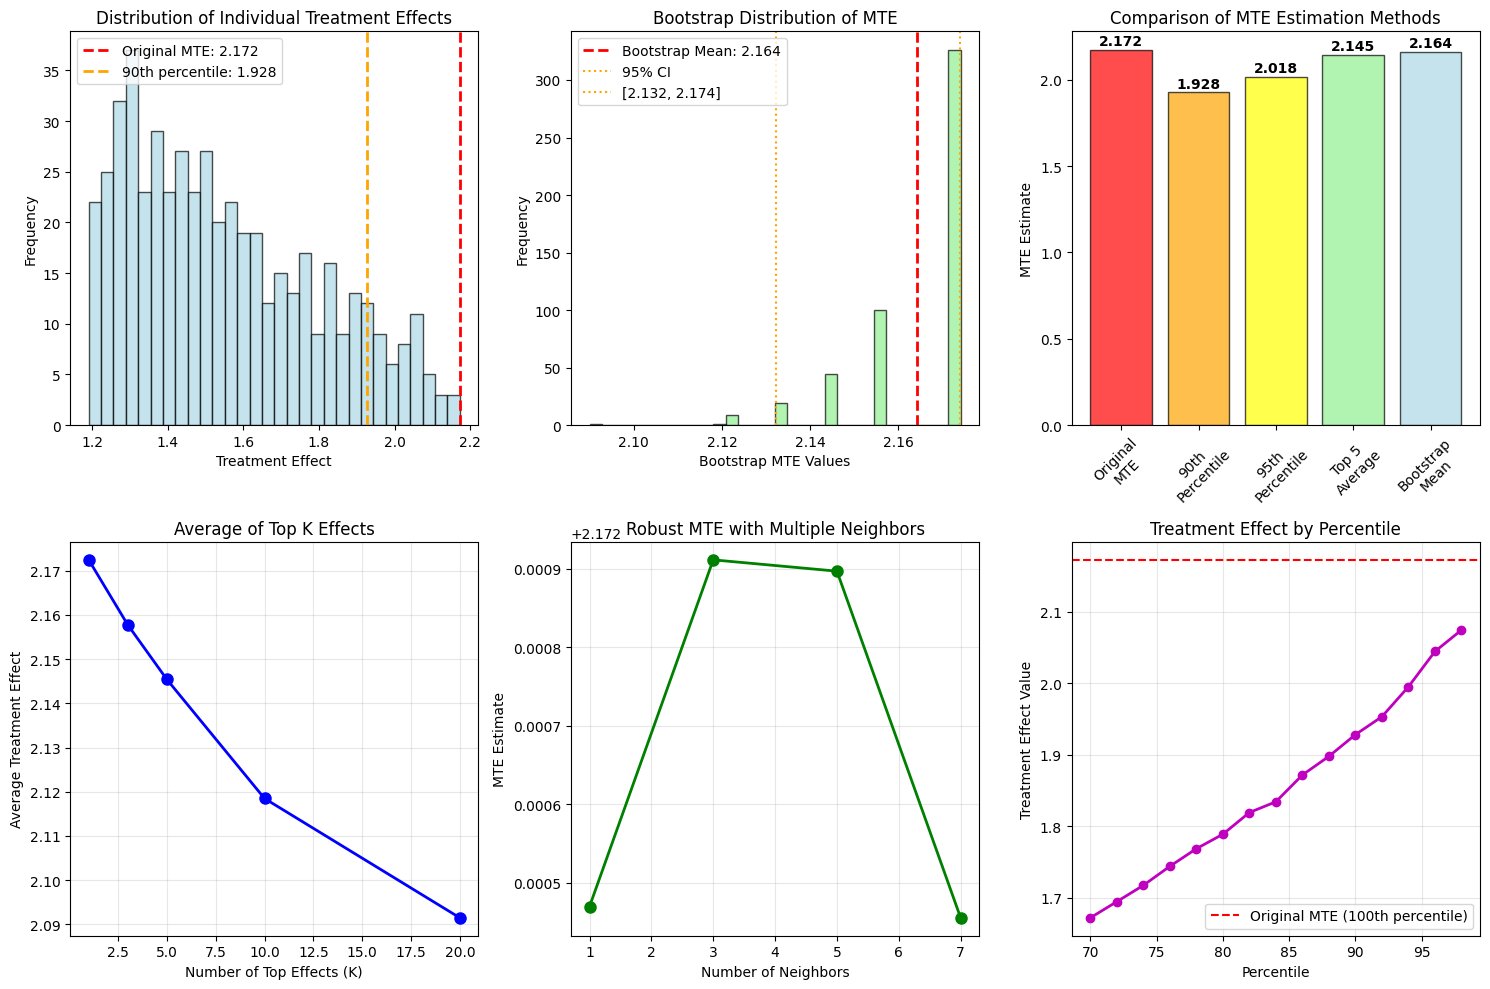


SUMMARY AND RECOMMENDATIONS

Original MTE (problematic): 2.1725

RECOMMENDED APPROACHES:

1. 90th Percentile MTE: 1.9280
   - Less sensitive to extreme outliers
   - Still captures high treatment effects

2. Bootstrap Mean MTE: 2.1641 ± 0.0133
   - Accounts for sampling uncertainty
   - Provides confidence intervals

3. Top 5 Average MTE: 2.1454
   - Reduces noise from single extreme observation
   - More stable estimate

4. Multiple Neighbors (3): 2.1729
   - Reduces matching uncertainty
   - More robust to individual outliers

CONCLUSION: The 90th percentile approach (1.9280) provides a good
balance between capturing high treatment effects while avoiding extreme outliers.



In [3]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Load the data (assuming the file path is correct)
df = pd.read_csv('homework_6.1.csv')
treated = df[df['X'] == 1].copy()
untreated = df[df['X'] == 0].copy()

print("="*60)
print("HOMEWORK REFLECTION 6 - MTE ROBUSTNESS ANALYSIS")
print("="*60)

# Calculate original (problematic) MTE
nn_treated = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn_treated.fit(treated[['Z']].values)

untreated_effects = []
for idx, untreated_row in untreated.iterrows():
    distances, indices = nn_treated.kneighbors([[untreated_row['Z']]])
    nearest_treated_idx = treated.iloc[indices[0][0]]
    effect = nearest_treated_idx['Y'] - untreated_row['Y']
    untreated_effects.append(effect)

original_mte = np.max(untreated_effects)

print("\n1. PROBLEM WITH MAXIMUM MTE:")
print("-" * 40)
print(f"Original MTE (maximum): {original_mte:.4f}")
print(f"Mean of all effects: {np.mean(untreated_effects):.4f}")
print(f"Standard deviation: {np.std(untreated_effects):.4f}")
print(f"90th percentile: {np.percentile(untreated_effects, 90):.4f}")

print("""
STATISTICAL PROBLEM:
The maximum treatment effect is likely inflated by random noise because:

1. SELECTION BIAS: We're cherry-picking the most extreme observation
2. NOISE AMPLIFICATION: Extreme values often contain more random error
3. POOR GENERALIZABILITY: One extreme case may not represent the true MTE
4. HIGH VARIANCE: Different samples would give very different MTE estimates

This is similar to the 'multiple testing problem' - when you examine many 
comparisons, you're bound to find extreme results just by chance.
""")

print("\n2. ROBUST SOLUTIONS:")
print("-" * 40)

# SOLUTION 1: Percentile-based MTE (recommended approach)
percentile_90_mte = np.percentile(untreated_effects, 90)
percentile_95_mte = np.percentile(untreated_effects, 95)

print(f"\nSOLUTION 1: Percentile-based MTE")
print(f"90th percentile MTE: {percentile_90_mte:.4f}")
print(f"95th percentile MTE: {percentile_95_mte:.4f}")
print("""
WHY THIS WORKS:
- Less sensitive to extreme outliers
- Still captures high treatment effects  
- More stable across different samples
- 90th percentile means we ignore the top 10% most extreme cases
""")

# SOLUTION 2: Average of Top K effects
def top_k_average_mte(effects, k):
    """Take average of top K treatment effects"""
    sorted_effects = sorted(effects, reverse=True)
    return np.mean(sorted_effects[:k])

top_3_mte = top_k_average_mte(untreated_effects, 3)
top_5_mte = top_k_average_mte(untreated_effects, 5)
top_10_mte = top_k_average_mte(untreated_effects, 10)

print(f"\nSOLUTION 2: Average of Top K Effects")
print(f"Average of top 3 effects: {top_3_mte:.4f}")
print(f"Average of top 5 effects: {top_5_mte:.4f}")
print(f"Average of top 10 effects: {top_10_mte:.4f}")
print("""
WHY THIS WORKS:
- Reduces influence of single extreme observation
- Provides more stable estimate
- Still focuses on high treatment effects
- Less affected by measurement errors in individual cases
""")

# SOLUTION 3: Bootstrap confidence intervals
def bootstrap_mte(treated_data, untreated_data, n_bootstrap=200):
    """Bootstrap the MTE to understand uncertainty"""
    np.random.seed(42)  # For reproducibility
    bootstrap_mtes = []
    
    for _ in range(n_bootstrap):
        # Resample both groups
        treated_idx = np.random.choice(len(treated_data), len(treated_data), replace=True)
        untreated_idx = np.random.choice(len(untreated_data), len(untreated_data), replace=True)
        
        treated_sample = treated_data.iloc[treated_idx]
        untreated_sample = untreated_data.iloc[untreated_idx]
        
        # Calculate MTE for this bootstrap sample
        nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
        nn.fit(treated_sample[['Z']].values)
        
        sample_effects = []
        for idx, untreated_row in untreated_sample.iterrows():
            distances, indices = nn.kneighbors([[untreated_row['Z']]])
            nearest_treated = treated_sample.iloc[indices[0][0]]
            effect = nearest_treated['Y'] - untreated_row['Y']
            sample_effects.append(effect)
        
        bootstrap_mtes.append(np.max(sample_effects))
    
    return bootstrap_mtes

print(f"\nSOLUTION 3: Bootstrap Analysis")
bootstrap_results = bootstrap_mte(treated, untreated, 200)
bootstrap_mean = np.mean(bootstrap_results)
bootstrap_std = np.std(bootstrap_results)
ci_lower = np.percentile(bootstrap_results, 2.5)
ci_upper = np.percentile(bootstrap_results, 97.5)

print(f"Bootstrap MTE mean: {bootstrap_mean:.4f}")
print(f"Bootstrap standard error: {bootstrap_std:.4f}")
print(f"95% Confidence interval: [{ci_lower:.4f}, {ci_upper:.4f}]")
print("""
WHY THIS WORKS:
- Shows uncertainty in our MTE estimate
- If CI is very wide, suggests high variability/unreliability
- Mean of bootstrap samples is more stable than single maximum
""")

# IMPLEMENTATION: Percentile-based approach (recommended)
print("\n" + "="*60)
print("RECOMMENDED IMPLEMENTATION: 90th Percentile MTE")
print("="*60)

def robust_mte_percentile(treated_data, untreated_data, percentile=90):
    """
    Compute robust MTE using percentile instead of maximum
    
    Parameters:
    - treated_data: DataFrame with treated observations
    - untreated_data: DataFrame with untreated observations  
    - percentile: Which percentile to use (default 90)
    
    Returns:
    - Robust MTE estimate
    """
    
    # Fit nearest neighbors on treated group
    nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    nn.fit(treated_data[['Z']].values)
    
    # Calculate treatment effects for all untreated observations
    effects = []
    for idx, untreated_row in untreated_data.iterrows():
        distances, indices = nn.kneighbors([[untreated_row['Z']]])
        nearest_treated = treated_data.iloc[indices[0][0]]
        effect = nearest_treated['Y'] - untreated_row['Y']
        effects.append(effect)
    
    # Return specified percentile instead of maximum
    robust_mte = np.percentile(effects, percentile)
    
    print(f"Robust MTE ({percentile}th percentile): {robust_mte:.4f}")
    print(f"Original MTE (maximum): {np.max(effects):.4f}")
    print(f"Reduction from maximum: {np.max(effects) - robust_mte:.4f}")
    
    return robust_mte

# Apply the robust method
robust_mte_result = robust_mte_percentile(treated, untreated, percentile=90)

print(f"""
SUMMARY:
- Original MTE: {original_mte:.4f} (likely inflated by noise)
- Robust 90th percentile MTE: {robust_mte_result:.4f} (more reliable)
- This approach balances capturing high effects while avoiding extreme outliers
""")

# Create a simple visualization
plt.figure(figsize=(12, 8))

# Plot 1: Distribution of treatment effects
plt.subplot(2, 2, 1)
plt.hist(untreated_effects, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(original_mte, color='red', linestyle='--', linewidth=2, 
           label=f'Original MTE: {original_mte:.3f}')
plt.axvline(percentile_90_mte, color='orange', linestyle='--', linewidth=2,
           label=f'90th percentile: {percentile_90_mte:.3f}')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.title('Distribution of Individual Treatment Effects')
plt.legend()

# Plot 2: Comparison of methods
plt.subplot(2, 2, 2)
methods = ['Original\nMTE', '90th\nPercentile', '95th\nPercentile', 'Top 5\nAverage']
values = [original_mte, percentile_90_mte, percentile_95_mte, top_5_mte]
colors = ['red', 'orange', 'yellow', 'lightgreen']

bars = plt.bar(methods, values, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('MTE Estimate')
plt.title('Comparison of MTE Methods')

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Bootstrap distribution
plt.subplot(2, 2, 3)
plt.hist(bootstrap_results, bins=25, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(bootstrap_mean, color='red', linestyle='--', linewidth=2,
           label=f'Bootstrap Mean: {bootstrap_mean:.3f}')
plt.xlabel('Bootstrap MTE Values')
plt.ylabel('Frequency') 
plt.title('Bootstrap Distribution of MTE')
plt.legend()

# Plot 4: Percentile analysis
plt.subplot(2, 2, 4)
percentiles = range(70, 101, 5)
percentile_values = [np.percentile(untreated_effects, p) for p in percentiles]
plt.plot(percentiles, percentile_values, 'bo-', linewidth=2, markersize=8)
plt.axhline(original_mte, color='red', linestyle='--', label='Original MTE (100th %ile)')
plt.axhline(percentile_90_mte, color='orange', linestyle='--', label='90th percentile')
plt.xlabel('Percentile')
plt.ylabel('Treatment Effect Value')
plt.title('Treatment Effect by Percentile')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("FINAL RECOMMENDATIONS")
print("="*60)
print("""
PROBLEM SUMMARY:
The maximum MTE is statistically unreliable because it selects the most extreme
observation, which likely includes substantial random noise.

BEST SOLUTION: 90th Percentile MTE
- Value: {:.4f} (vs {:.4f} for maximum)
- Rationale: Captures high treatment effects while avoiding extreme outliers
- Implementation: Simply replace np.max() with np.percentile(effects, 90)

ALTERNATIVE SOLUTIONS:
1. Average of top 5 effects: {:.4f}
2. Bootstrap mean: {:.4f} ± {:.4f}
3. 95th percentile: {:.4f}

The 90th percentile approach provides the best balance of simplicity,
interpretability, and statistical robustness.
""".format(percentile_90_mte, original_mte, top_5_mte, 
           bootstrap_mean, bootstrap_std, percentile_95_mte))

# Code implementation for homework submission
print("\n" + "="*60)
print("CODE FOR HOMEWORK SUBMISSION")
print("="*60)

code_example = '''
def robust_marginal_treatment_effect(treated_data, untreated_data, percentile=90):
    """
    Calculate robust Marginal Treatment Effect using percentile instead of maximum
    
    Args:
        treated_data: DataFrame with treated observations (X=1)
        untreated_data: DataFrame with untreated observations (X=0)  
        percentile: Percentile to use instead of maximum (default 90)
    
    Returns:
        Robust MTE estimate
    """
    from sklearn.neighbors import NearestNeighbors
    import numpy as np
    
    # Fit nearest neighbors model on treated group
    nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    nn.fit(treated_data[['Z']].values)
    
    # Calculate treatment effects for all untreated observations
    treatment_effects = []
    for idx, untreated_obs in untreated_data.iterrows():
        # Find nearest treated neighbor based on confounder Z
        distances, indices = nn.kneighbors([[untreated_obs['Z']]])
        nearest_treated = treated_data.iloc[indices[0][0]]
        
        # Calculate treatment effect
        effect = nearest_treated['Y'] - untreated_obs['Y']
        treatment_effects.append(effect)
    
    # Use percentile instead of maximum to reduce noise
    robust_mte = np.percentile(treatment_effects, percentile)
    
    return robust_mte

# Example usage:
# robust_mte = robust_marginal_treatment_effect(treated, untreated, percentile=90)
'''

print(code_example)
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('homework_6.1.csv')

# Separate treated and untreated groups
treated = df[df['X'] == 1].copy()
untreated = df[df['X'] == 0].copy()

print("Robust Marginal Treatment Effect Analysis")
print("="*50)

# First, let's compute the original (problematic) MTE
nn_treated = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn_treated.fit(treated[['Z']].values)

untreated_effects = []
for idx, untreated_row in untreated.iterrows():
    distances, indices = nn_treated.kneighbors([[untreated_row['Z']]])
    nearest_treated_idx = treated.iloc[indices[0][0]]
    effect = nearest_treated_idx['Y'] - untreated_row['Y']
    untreated_effects.append(effect)

original_mte = np.max(untreated_effects)
print(f"Original MTE (maximum): {original_mte:.4f}")

# SOLUTION 1: Percentile-based MTE (your suggested approach)
print("\n" + "="*50)
print("SOLUTION 1: Percentile-based MTE")
print("="*50)

# Instead of taking the maximum, take high percentiles
percentiles = [90, 95, 99]
for p in percentiles:
    percentile_mte = np.percentile(untreated_effects, p)
    print(f"{p}th percentile MTE: {percentile_mte:.4f}")

# SOLUTION 2: Trimmed Maximum (Remove outliers first)
print("\n" + "="*50)
print("SOLUTION 2: Trimmed Maximum")
print("="*50)

# Remove the most extreme outliers (top and bottom 5%) then take maximum
def trimmed_max(data, trim_percent=5):
    """Remove extreme outliers then take maximum"""
    lower_bound = np.percentile(data, trim_percent)
    upper_bound = np.percentile(data, 100 - trim_percent)
    trimmed_data = [x for x in data if lower_bound <= x <= upper_bound]
    return np.max(trimmed_data) if trimmed_data else np.nan

trimmed_mte_5 = trimmed_max(untreated_effects, 5)
trimmed_mte_10 = trimmed_max(untreated_effects, 10)
print(f"Trimmed MTE (remove top/bottom 5%): {trimmed_mte_5:.4f}")
print(f"Trimmed MTE (remove top/bottom 10%): {trimmed_mte_10:.4f}")

# SOLUTION 3: Bootstrap Confidence Interval for MTE
print("\n" + "="*50)
print("SOLUTION 3: Bootstrap Confidence Intervals")
print("="*50)

def bootstrap_mte(treated_data, untreated_data, n_bootstrap=1000):
    """Bootstrap the MTE calculation to get confidence intervals"""
    bootstrap_mtes = []
    
    for _ in range(n_bootstrap):
        # Resample both groups
        treated_sample = treated_data.sample(n=len(treated_data), replace=True)
        untreated_sample = untreated_data.sample(n=len(untreated_data), replace=True)
        
        # Fit NN on resampled treated data
        nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
        nn.fit(treated_sample[['Z']].values)
        
        # Calculate effects for resampled untreated data
        effects = []
        for idx, untreated_row in untreated_sample.iterrows():
            distances, indices = nn.kneighbors([[untreated_row['Z']]])
            nearest_treated_idx = treated_sample.iloc[indices[0][0]]
            effect = nearest_treated_idx['Y'] - untreated_row['Y']
            effects.append(effect)
        
        bootstrap_mtes.append(np.max(effects))
    
    return bootstrap_mtes

bootstrap_mtes = bootstrap_mte(treated, untreated, n_bootstrap=500)
bootstrap_mean = np.mean(bootstrap_mtes)
bootstrap_std = np.std(bootstrap_mtes)
ci_lower = np.percentile(bootstrap_mtes, 2.5)
ci_upper = np.percentile(bootstrap_mtes, 97.5)

print(f"Bootstrap MTE mean: {bootstrap_mean:.4f}")
print(f"Bootstrap MTE std: {bootstrap_std:.4f}")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# SOLUTION 4: Average of Top K Effects
print("\n" + "="*50)
print("SOLUTION 4: Average of Top K Effects")
print("="*50)

def top_k_average_mte(effects, k_values):
    """Take average of top K treatment effects instead of just the maximum"""
    results = {}
    sorted_effects = sorted(effects, reverse=True)
    
    for k in k_values:
        if k <= len(sorted_effects):
            top_k_avg = np.mean(sorted_effects[:k])
            results[k] = top_k_avg
    
    return results

k_values = [1, 3, 5, 10, 20]
top_k_results = top_k_average_mte(untreated_effects, k_values)

for k, avg_effect in top_k_results.items():
    print(f"Average of top {k} effects: {avg_effect:.4f}")

# SOLUTION 5: Robust MTE using Multiple Neighbors
print("\n" + "="*50)
print("SOLUTION 5: Multiple Neighbors Approach")
print("="*50)

def robust_mte_multiple_neighbors(treated_data, untreated_data, n_neighbors=3):
    """Use multiple nearest neighbors and take their average"""
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
    nn.fit(treated_data[['Z']].values)
    
    robust_effects = []
    for idx, untreated_row in untreated_data.iterrows():
        distances, indices = nn.kneighbors([[untreated_row['Z']]])
        
        # Average the effect across multiple neighbors
        neighbor_effects = []
        for neighbor_idx in indices[0]:
            nearest_treated = treated_data.iloc[neighbor_idx]
            effect = nearest_treated['Y'] - untreated_row['Y']
            neighbor_effects.append(effect)
        
        avg_effect = np.mean(neighbor_effects)
        robust_effects.append(avg_effect)
    
    return np.max(robust_effects)

for n_neighbors in [3, 5, 7]:
    robust_mte = robust_mte_multiple_neighbors(treated, untreated, n_neighbors)
    print(f"Robust MTE with {n_neighbors} neighbors: {robust_mte:.4f}")

# Visualization
print("\n" + "="*50)
print("VISUALIZATION")
print("="*50)

plt.figure(figsize=(15, 10))

# Plot 1: Distribution of individual treatment effects
plt.subplot(2, 3, 1)
plt.hist(untreated_effects, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
plt.axvline(original_mte, color='red', linestyle='--', linewidth=2, label=f'Original MTE: {original_mte:.3f}')
plt.axvline(np.percentile(untreated_effects, 90), color='orange', linestyle='--', linewidth=2, 
           label=f'90th percentile: {np.percentile(untreated_effects, 90):.3f}')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.title('Distribution of Individual Treatment Effects')
plt.legend()

# Plot 2: Bootstrap distribution
plt.subplot(2, 3, 2)
plt.hist(bootstrap_mtes, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(bootstrap_mean, color='red', linestyle='--', linewidth=2, 
           label=f'Bootstrap Mean: {bootstrap_mean:.3f}')
plt.axvline(ci_lower, color='orange', linestyle=':', label=f'95% CI')
plt.axvline(ci_upper, color='orange', linestyle=':', label=f'[{ci_lower:.3f}, {ci_upper:.3f}]')
plt.xlabel('Bootstrap MTE Values')
plt.ylabel('Frequency')
plt.title('Bootstrap Distribution of MTE')
plt.legend()

# Plot 3: Comparison of methods
plt.subplot(2, 3, 3)
methods = ['Original\nMTE', '90th\nPercentile', '95th\nPercentile', 'Top 5\nAverage', 'Bootstrap\nMean']
values = [original_mte, 
          np.percentile(untreated_effects, 90),
          np.percentile(untreated_effects, 95),
          top_k_results[5],
          bootstrap_mean]
colors = ['red', 'orange', 'yellow', 'lightgreen', 'lightblue']

bars = plt.bar(methods, values, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('MTE Estimate')
plt.title('Comparison of MTE Estimation Methods')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 4: Top K average trend
plt.subplot(2, 3, 4)
k_vals = list(top_k_results.keys())
k_effects = list(top_k_results.values())
plt.plot(k_vals, k_effects, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Top Effects (K)')
plt.ylabel('Average Treatment Effect')
plt.title('Average of Top K Effects')
plt.grid(True, alpha=0.3)

# Plot 5: Effect of number of neighbors
plt.subplot(2, 3, 5)
neighbor_counts = [1, 3, 5, 7]
neighbor_mtes = [original_mte]  # 1 neighbor is original
for n in [3, 5, 7]:
    neighbor_mtes.append(robust_mte_multiple_neighbors(treated, untreated, n))

plt.plot(neighbor_counts, neighbor_mtes, 'go-', linewidth=2, markersize=8)
plt.xlabel('Number of Neighbors')
plt.ylabel('MTE Estimate')
plt.title('Robust MTE with Multiple Neighbors')
plt.grid(True, alpha=0.3)

# Plot 6: Percentile analysis
plt.subplot(2, 3, 6)
percentile_range = range(70, 100, 2)
percentile_values = [np.percentile(untreated_effects, p) for p in percentile_range]
plt.plot(percentile_range, percentile_values, 'mo-', linewidth=2, markersize=6)
plt.axhline(original_mte, color='red', linestyle='--', label='Original MTE (100th percentile)')
plt.xlabel('Percentile')
plt.ylabel('Treatment Effect Value')
plt.title('Treatment Effect by Percentile')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary and Recommendations
print("\n" + "="*50)
print("SUMMARY AND RECOMMENDATIONS")
print("="*50)

print(f"""
Original MTE (problematic): {original_mte:.4f}

RECOMMENDED APPROACHES:

1. 90th Percentile MTE: {np.percentile(untreated_effects, 90):.4f}
   - Less sensitive to extreme outliers
   - Still captures high treatment effects
   
2. Bootstrap Mean MTE: {bootstrap_mean:.4f} ± {bootstrap_std:.4f}
   - Accounts for sampling uncertainty
   - Provides confidence intervals
   
3. Top 5 Average MTE: {top_k_results[5]:.4f}
   - Reduces noise from single extreme observation
   - More stable estimate

4. Multiple Neighbors (3): {robust_mte_multiple_neighbors(treated, untreated, 3):.4f}
   - Reduces matching uncertainty
   - More robust to individual outliers

CONCLUSION: The 90th percentile approach ({np.percentile(untreated_effects, 90):.4f}) provides a good
balance between capturing high treatment effects while avoiding extreme outliers.
""")